In [2]:
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import os

#(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

2024-06-27 21:21:17.739404: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-27 21:21:18.270902: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 21:21:19.277089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
#Charger nos données : 
def load_image_data(data_dir, img_size=(28, 28)):
    labels = ['portrait', 'other']
    data = []
    label_data = []
    for label in labels:
        folder_path = os.path.join(data_dir, label)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = load_img(img_path, target_size=img_size, color_mode='grayscale')
            img_array = img_to_array(img).astype('float32') / 255.0
            data.append(img_array.flatten())
            label_data.append(labels.index(label))
    data, label_data = shuffle(np.array(data), np.array(label_data))
    return data, label_data

data_train, label_train = load_image_data('../../data/binary')

In [4]:
def preprocess_data(X_train):
    
    X_train = X_train.astype('float32')
    
    # Aplatissement des images 28x28 en vecteurs de 784 éléments
    X_train_flattened = X_train.reshape((X_train.shape[0], -1))
    
    # Standardisation
    mean = X_train_flattened.mean(axis=0)
    std = X_train_flattened.std(axis=0)
    
    epsilon = 1e-8 # Pour éviter la division par zéro
    std += epsilon
    
    X_train_standardized = (X_train_flattened - mean) / std
    
    return X_train_standardized, std, mean, X_train_flattened

X_train_standardized, std, mean, X_train_flattened = preprocess_data(data_train)

Compréssion / Décompression

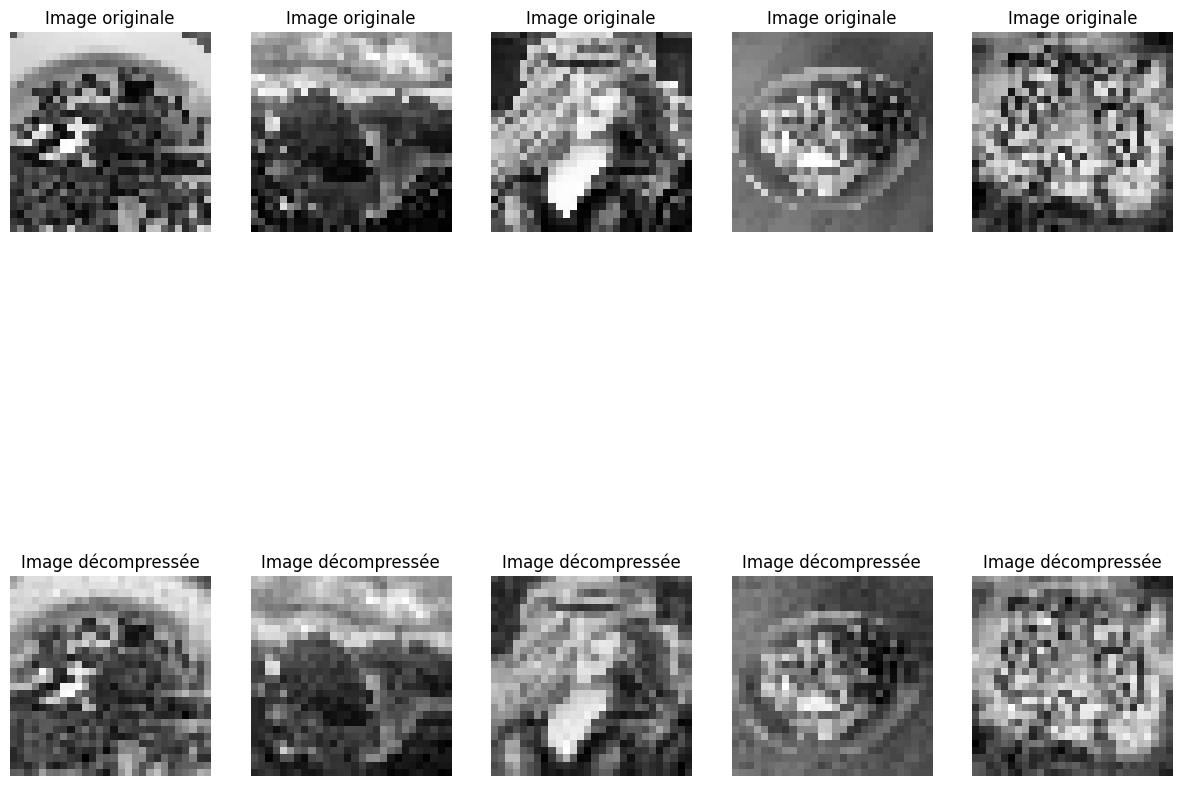

In [7]:
#Valeurs propres et vecteurs propres
def values_and_vectors(data_standardized):
    cov_matrix = np.cov(data_standardized, rowvar=False)  #Matrice de covariance
    values, vectors = np.linalg.eigh(cov_matrix)  #Valeurs propres et les vecteurs propres
    return values, vectors

values_train, vectors_trains = values_and_vectors(X_train_standardized)


k = 500

X_train_compressed = np.dot(X_train_standardized, vectors_trains[:, -k:])

X_train_reconstructed = np.dot(X_train_compressed, vectors_trains[:, -k:].T) * std + mean

num_examples = 5
plt.figure(figsize=(15, 10))

#Affichage
for i in range(num_examples):
    
    plt.subplot(3, num_examples, i + 1)
    plt.title("Image originale")
    plt.imshow(X_train_flattened[i].reshape((28, 28)), cmap='gray')
    plt.axis('off')

    
    plt.subplot(3, num_examples, i + 1 + 2 * num_examples)
    plt.title("Image décompressée")
    plt.imshow(X_train_reconstructed[i].reshape((28, 28)), cmap='gray')
    plt.axis('off')

plt.show()

Projection 2D/3D

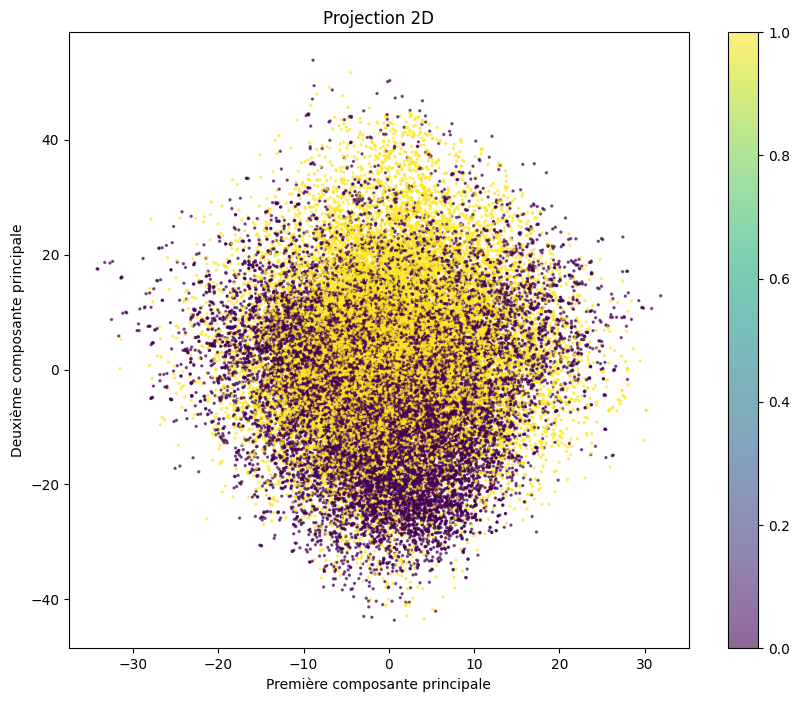

In [22]:
k = 2
X_train_2d = np.dot(X_train_standardized, vectors_trains[:, -k:])

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=label_train, cmap='viridis', alpha=0.6, s=2)
plt.colorbar(scatter)
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.title('Projection 2D')
plt.show()

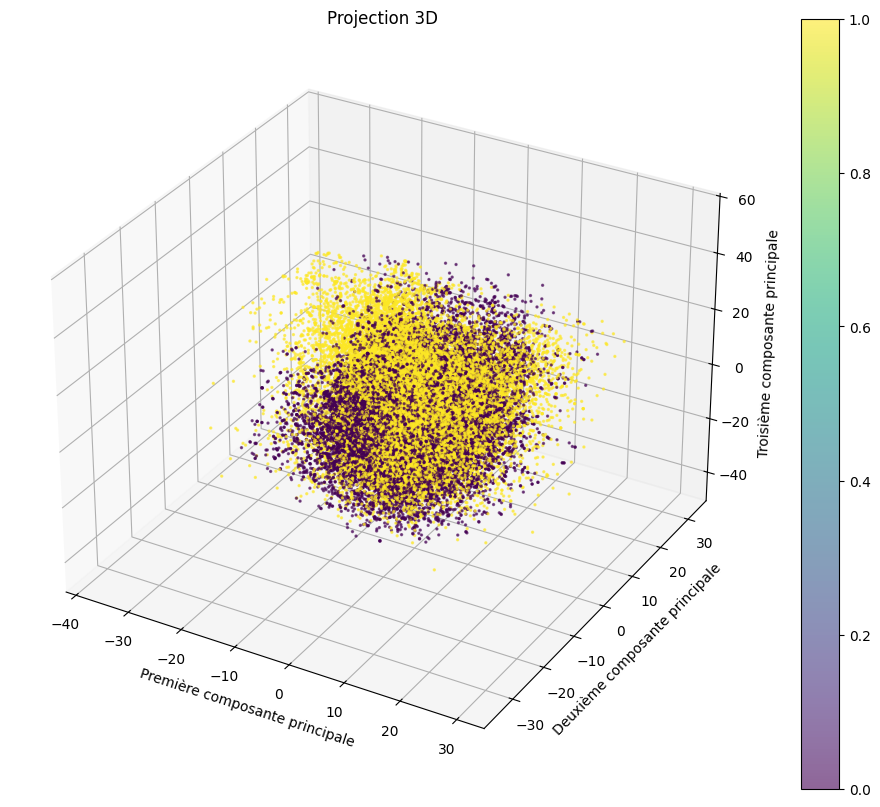

In [24]:
k = 3
X_train_3d = np.dot(X_train_standardized, vectors_trains[:, -k:])

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_3d[:, 0], X_train_3d[:, 1], X_train_3d[:, 2], c=label_train, cmap='viridis', alpha=0.6, s=2)
plt.colorbar(scatter)
ax.set_xlabel('Première composante principale')
ax.set_ylabel('Deuxième composante principale')
ax.set_zlabel('Troisième composante principale')
plt.title('Projection 3D')
plt.show()

Génération de nouvelles données

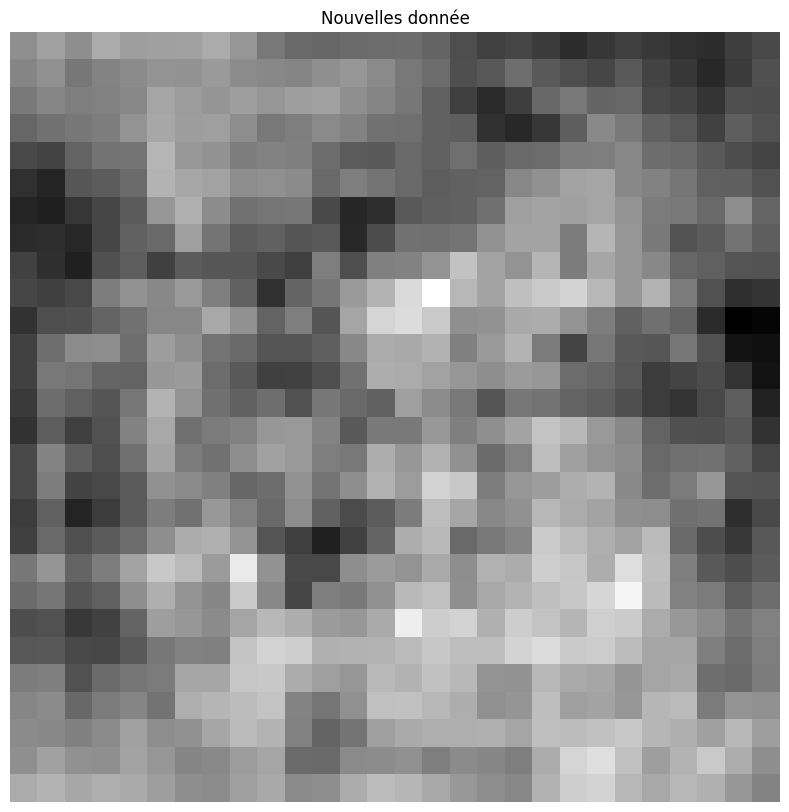

In [43]:
k = 500
X_train_compressed = np.dot(X_train_standardized, vectors_trains[:, -k:])

#moyennes et écart types
mean_compressed = X_train_compressed.mean(axis=0)
std_compressed = X_train_compressed.std(axis=0)

#new data

new_data_compressed = np.random.normal(loc=mean_compressed, scale=std_compressed, size=(num_new_samples, k))


new_data = np.dot(new_data_compressed, vectors_trains[:, -k:].T) * std + mean


plt.figure(figsize=(15, 10))


   
plt.imshow(new_data[i].reshape((28, 28)), cmap='gray')
plt.axis('off')
plt.title(f"Nouvelles donnée")

plt.show()